#1 Instalación de librerías

In [ ]:
!pip install PyPDF2 nltk wordcloud
!pip install dateparser

import os
import re
import string
from collections import Counter
import pandas as pd
import nltk
import dateparser
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from PyPDF2 import PdfReader
from nltk.tokenize import sent_tokenize, word_tokenize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 6.4 MB/s eta 0:00:00


In [ ]:
# Descargar recursos de NLTK
nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download("stopwords")
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#2. Montar ruta de los archivos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ruta_carpeta = "/content/drive/MyDrive/Minutas Banco de Mexico"

#3. Funciones de procesamiento

In [ ]:
def extraer_texto_pdf(ruta_pdf):
    try:
        reader = PdfReader(ruta_pdf)
        text = "\n".join([page.extract_text() for page in reader.pages if page.extract_text()])
        return text.encode('utf-8').decode('utf-8')
    except:
        return ""

def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'\n+', ' ', texto)
    texto = re.sub(rf"[{re.escape(string.punctuation)}]", '', texto)
    return texto


def limpiar_nombre(nombre):
    nombre = nombre.lower()
    nombre = nombre.strip().replace("{", "").replace("}", "").replace(".pdf", "")
    return nombre

def extraer_keywords(texto_limpio, top_n=5):
    tokens = word_tokenize(texto_limpio)
    tokens_filtrados = [t for t in tokens if t not in stop_words and len(t) > 2]
    frecuencias = Counter(tokens_filtrados)
    return ", ".join([pal for pal, _ in frecuencias.most_common(top_n)])

def numero_minuta(texto_portada):
    match = re.search(r'\bminuta\s+número\s+(\d+)', texto_portada.lower())
    if match:
        return int(match.group(1))
    return 0

def extraer_fecha_desde_texto(texto_portada):
    patron = r"anunciada el (\d{1,2} de [a-zA-Z]+ de \d{4})"
    coincidencia = re.search(patron, texto_portada.lower())

    if coincidencia:
        fecha_str = coincidencia.group(1)
        fecha = dateparser.parse(fecha_str, languages=["es"])
        if fecha:
            return fecha.strftime("%Y-%m-%d")
    else:
        return None



#4. Leer los archivos

In [ ]:
registros = []
#max = 2 #Valor para pruebas
for archivo in os.listdir(ruta_carpeta):
    if archivo.endswith(".pdf"):
        ruta = os.path.join(ruta_carpeta, archivo)
        texto = extraer_texto_pdf(ruta)
        texto_limpio = limpiar_texto(texto)

        num_palabras = len(word_tokenize(texto_limpio))
        num_oraciones = len(sent_tokenize(texto))

        fecha = "desconocida"
        decision = "desconocida"

        palabras_clave = extraer_keywords(texto_limpio)

        registros.append({
            "ID": limpiar_nombre(archivo),
            "Numero" : numero_minuta(texto_limpio[:200]),
            "Fecha": extraer_fecha_desde_texto(texto_limpio[:200]),
            "Texto limpio": texto_limpio,
            "Numero palabras": num_palabras,
            "Numero oraciones": num_oraciones,
            "Palabras clave dominantes": palabras_clave
        })
        """
        if max!= None & (len(registros) > max ):
            break
            """

# 5. Análisis exploratorio

## Datos generales

In [ ]:
df = pd.DataFrame(registros)
df.head()

,ID,Numero,Fecha,Texto limpio,Numero palabras,Numero oraciones,Palabras clave dominantes
0,df53bdc1-88ec-276e-718c-aec8de5282b4,112,2024-11-14,minuta número 112 reunión de la junta de gobie...,16032,654,"inflación, subyacente, tasa, monetaria, gráfica"
1,209f9f3a-d49b-51d1-0460-9b3ea1d9ebab,111,None,minuta número 111 reunión de la junta de gobie...,15821,626,"inflación, tasa, 2024, monetaria, subyacente"
2,c2f0671d-b457-a331-aded-f498f00f0385,110,2024-08-08,minuta número 110 reunión de la junta de gobie...,16465,646,"inflación, tasa, subyacente, 2024, monetaria"
3,f13fd839-189c-cf58-bf54-025b6ffe559f,109,2024-06-27,minuta número 109 reunión de la junta de gobie...,15932,615,"inflación, tasa, monetaria, tasas, 2024"
4,718151b0-83f7-7381-35e1-592a83d30e6e,108,2024-05-09,minuta número 108 reunión de la junta de gobie...,16113,628,"inflación, tasa, monetaria, 2024, gráfica"


In [ ]:
# Inspeccionando las columnas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         114 non-null    object
 1   Numero                     114 non-null    int64 
 2   Fecha                      105 non-null    object
 3   Texto limpio               114 non-null    object
 4   Numero palabras            114 non-null    int64 
 5   Numero oraciones           114 non-null    int64 
 6   Palabras clave dominantes  114 non-null    object
dtypes: int64(3), object(4)
memory usage: 6.4+ KB


## Valores faltantes

In [ ]:
# Calculando porcentajes de valores faltantes
df.isna().sum() / len(df)

,0
ID,0.000000
Numero,0.000000
Fecha,0.078947
Texto limpio,0.000000
Numero palabras,0.000000
Numero oraciones,0.000000
Palabras clave dominantes,0.000000


Se observa que el único dato que no se pudo extrar por completo por ahora es la fecha de la minuta, apesar de que cada minuta cuenta con su fecha en el texto.

## Análisis de variables numéricas

In [ ]:
# Tendencia central (media, mediana), Dispersión (min, max, desviación estándar y cuartiles)
df.describe()

,Numero,Numero palabras,Numero oraciones
count,114.000000,114.000000,114.000000
mean,57.517544,13315.622807,455.991228
std,33.083224,2446.794505,104.969738
min,1.000000,5734.000000,6.000000
25%,29.250000,11212.000000,373.000000
50%,57.500000,13785.500000,458.500000
75%,85.750000,15337.000000,532.500000
max,115.000000,17493.000000,654.000000


Se observa que el número de oraciones tiene un mínimo de 6 oraciones, por lo
que probablemente una minuta se haya procesado mal o se tenga el archivo PDF incorrecto.

array([[<Axes: title={'center': 'Numero'}>,
        <Axes: title={'center': 'Numero palabras'}>],
       [<Axes: title={'center': 'Numero oraciones'}>, <Axes: >]],
      dtype=object)

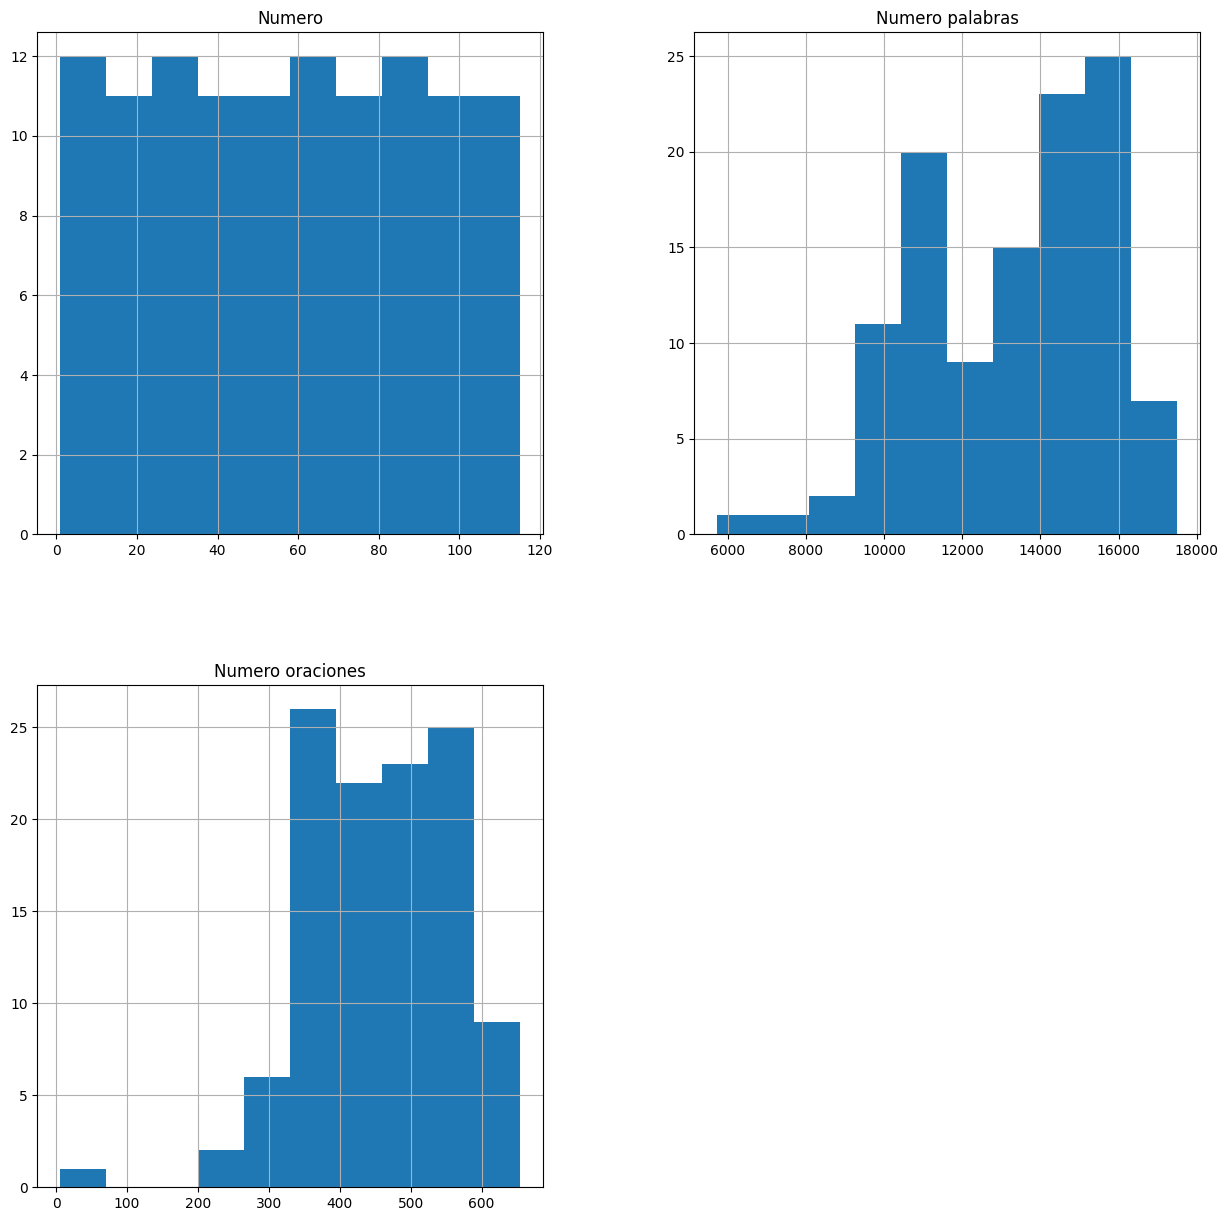

In [ ]:
# Histogramas de las variables numéricas
df.hist(figsize=(15,15))

Los números de minutas se observan uniformemente distribuidos ya que se cuenta con un número secuencial por minuta.

Los números de palabras y de oraciones presentan sesgos a la derecha, indicando que hay algunas minutas son atípicamente cortas. Se podrá analizar más a detalle lo que sucede con ellas.

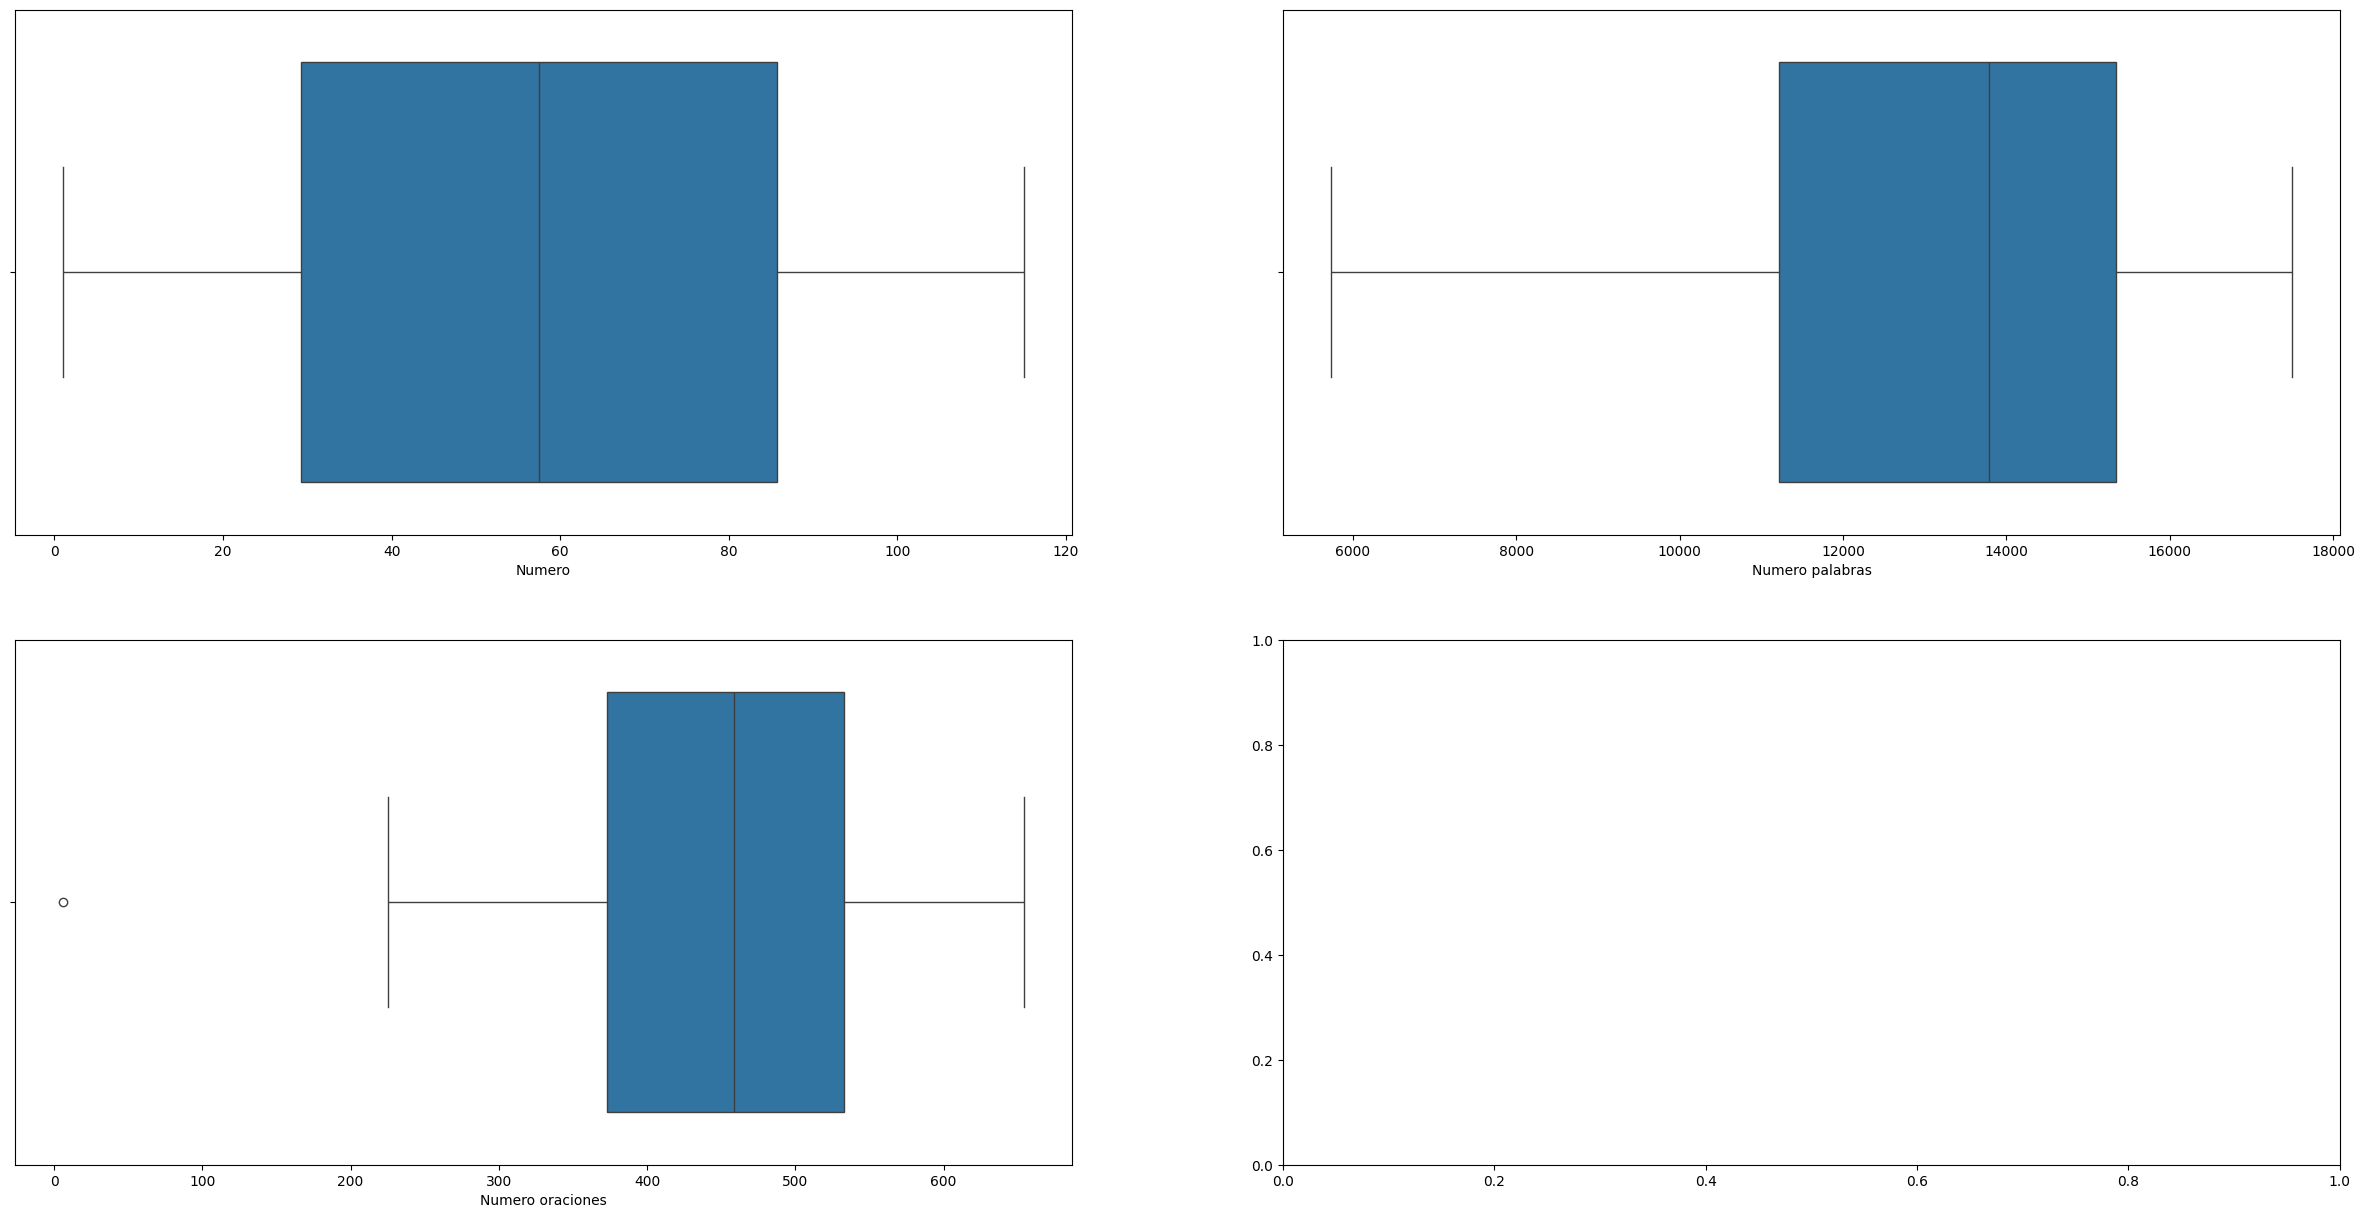

In [ ]:
# Boxplots para ver los cuartiles de los datos y valores atípicos
num_cols = df.select_dtypes(include=np.number).columns.tolist()
fig, axes = plt.subplots(2,2, figsize=(30,15))
axes = axes.ravel()
for col, ax in zip(df[num_cols], axes):
  sns.boxplot(x=df[col], ax=ax)
  ax.set(xlabel=f'{col}')

No se observan muchos valores atípicos salvo el de la minuta de 6 oraciones.

In [ ]:
# Análisis de las fechas de las minutas
df["Fecha timeseries"] = pd.to_datetime(df["Fecha"], errors="coerce")

df["Mes"] = df["Fecha timeseries"].dt.to_period("M").astype(str)
df["Año"] = df["Fecha timeseries"].dt.to_period("Y").astype(str)

<Axes: >

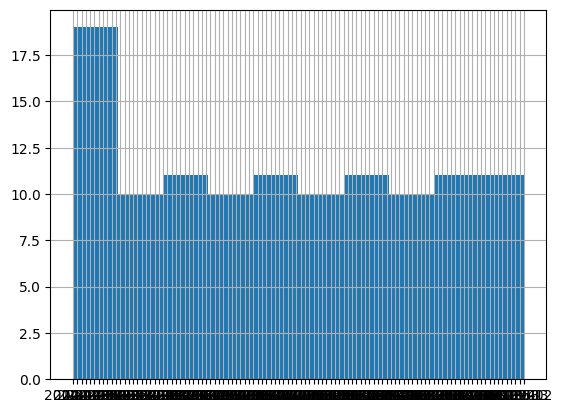

In [ ]:
df["Mes"].hist()

<Axes: >

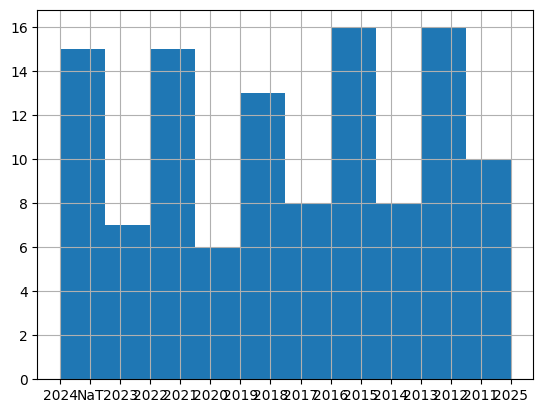

In [ ]:
df["Año"].hist()

## Análisis de variables categóricas

In [ ]:
df.describe(include='object')

,ID,Fecha,Texto limpio,Palabras clave dominantes,Mes,Año
count,114,105,114,114,114,114
unique,114,105,114,110,106,16
top,df53bdc1-88ec-276e-718c-aec8de5282b4,2024-11-14,minuta número 112 reunión de la junta de gobie...,"inflación, tasa, monetaria, 2024, gráfica",NaT,NaT
freq,1,1,1,2,9,9


Distribución de clases de la variable 'Decision':
Decision
desconocido    114
Name: count, dtype: int64


<ipython-input-67-b3d9dac5a64e>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Decision", data=df, palette="Set2")


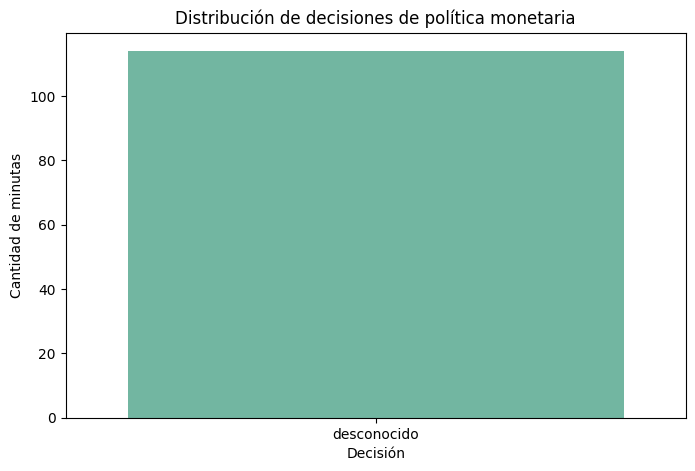

In [ ]:
# Clasificación mejorada basada en frases reales de las minutas
def clasificar_decision(texto):
    texto = texto.lower()

    patrones_mantener = [
        "la junta decidió mantener",
        "se decidió mantener",
        "se mantuvo el objetivo"
    ]
    patrones_subir = [
        "la junta decidió aumentar",
        "se decidió aumentar",
        "se incrementó la tasa"
    ]
    patrones_bajar = [
        "la junta decidió reducir",
        "se decidió reducir",
        "se bajó la tasa"
    ]

    for patron in patrones_mantener:
        if patron in texto:
            return "mantener"
    for patron in patrones_subir:
        if patron in texto:
            return "subir"
    for patron in patrones_bajar:
        if patron in texto:
            return "bajar"

    return "desconocido"

# Aplicar clasificación
df["Decision"] = df["Texto limpio"].apply(clasificar_decision)

# Verificar conteo
print("Distribución de clases de la variable 'Decision':")
print(df["Decision"].value_counts())

# Visualizar en gráfico
plt.figure(figsize=(8, 5))
sns.countplot(x="Decision", data=df, palette="Set2")
plt.title("Distribución de decisiones de política monetaria")
plt.xlabel("Decisión")
plt.ylabel("Cantidad de minutas")
plt.show()
